```R
install.packages("tensorflow")
install.packages("keras")
install.packages("ISLR2")
install.packages("glmnet")
```

In [31]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

In [204]:
tf.__version__, tf.keras.__version__

('2.4.1', '2.4.0')

# Red neuronal de una capa (Hitters)

Configuramos los datos `Hitters` y separamos un conjunto de entrenamiento y de prueba:

```R
library(ISLR2)
Gitters <- na.omit(Hitters)
n <- nrow(Gitters)
set.seed(13)
ntest <- trunc(n / 3)
testid <- sample(1:n, ntest)
```

In [32]:
# Reseto el índice del dataframe a 0, 1, ... para evitar problemas más adelante
hitters = pd.read_csv("../data/hitters.csv").dropna().reset_index()
n = hitters.shape[0]
np.random.seed(13)
ntest = n // 3
testid = np.random.choice(n, ntest, replace=False)

Ajustamos un modelo lineal.

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

A la regresión de `sklearn.linear_model.LinearRegression` hay que proveerle una matriz de diseño y una respuesta numérica siempre, así que las construimos ahora. Como hay algunas columnas categóricas, usamos un OneHotEncoder descartando los niveles redundantes:   

In [35]:
X = hitters.drop(columns="Salary")
y = hitters.Salary.values
X.shape, y.shape

categorical_features = X.columns[X.dtypes == "O"].tolist()
X_cat, X_num = X[categorical_features], X.drop(columns=categorical_features)
ohe = OneHotEncoder(drop="first", sparse=False).fit(X_cat)

X = pd.concat(
    [
        pd.DataFrame(
            data=ohe.transform(X_cat).astype(int),
            columns=ohe.get_feature_names_out(categorical_features)
        ),
        X_num,
    ],
    axis=1,
).values
X[:5,]

array([[   1,    1,    1,    1,  315,   81,    7,   24,   38,   39,   14,
        3449,  835,   69,  321,  414,  375,  632,   43,   10],
       [   0,    1,    0,    2,  479,  130,   18,   66,   72,   76,    3,
        1624,  457,   63,  224,  266,  263,  880,   82,   14],
       [   1,    0,    1,    3,  496,  141,   20,   65,   78,   37,   11,
        5628, 1575,  225,  828,  838,  354,  200,   11,    3],
       [   1,    0,    1,    4,  321,   87,   10,   39,   42,   30,    2,
         396,  101,   12,   48,   46,   33,  805,   40,    4],
       [   0,    1,    0,    5,  594,  169,    4,   74,   51,   35,   11,
        4408, 1133,   19,  501,  336,  194,  282,  421,   25]])

In [36]:
X_train, X_test = X[testid], X[~testid]
y_train, y_test = y[testid], y[~testid]

```R
lfit <- lm(Salary ~ ., data = Gitters[-testid, ])
lpred <- predict(lfit, Gitters[testid, ])
with(Gitters[testid, ], mean(abs(lpred - Salary)))
```

In [37]:
from sklearn.metrics import mean_absolute_error as mae

In [38]:
lfit = LinearRegression().fit(X_train, y_train)
lpred = lfit.predict(X_test)
mae(y_test, lpred)

256.98142425265854

El paquete `glmnet` no usa fórmulas, preparamos a mano $x$ e $y$.

```R
x <- scale(model.matrix(Salary ~ . - 1, data = Gitters))
y <- Gitters$Salary
```

Ajustamos una modelo ridge:

**Nota del pythonista:** acá hay una imprecisión me parece: `cv.glmnet` hace validación cruzada para encontrar el parámetro $\lambda$ de una regresión "de red elástica" `glmnet`. Por [defecto](https://rdrr.io/cran/glmnet/man/glmnet.html), `glmnet` toma $\alpha=1$, que es equivalente a una penalidad _lasso_ pura, como lo dice la documentación:
> "`alpha=1` is the lasso penalty, and `alpha=0` the ridge penalty."

Es decir, la regresión que se entrena en la versión en R de este notebook, es un modelo _lasso_, no _ridge_. Para mantener paridad, fiteamos por CV un modelo _lasso_. Normalmente, a tal fin alcanzaría con usar `sklearn.linear_model.LassoCV`, pero como se pretende medir la pérdida con una función de error medio _absoluto_, y no el tradicional cuadrático, habrá que usar `sklearn.model_selection.GridSearchCV`, que da bastante flexibilidad al contenido de la validación cruzada.

```R
library (glmnet)
cvfit <- cv.glmnet(x[-testid, ], y[-testid], type.measure = "mae")
cpred <- predict(cvfit , x[testid, ], s = "lambda.min")
mean(abs(y[testid] - cpred))
```

In [39]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV

In [40]:
cvfit = LassoCV(max_iter=10000).fit(X_train, y_train)
cvpred = cvfit.predict(X_test)
cvfit.alpha_, mae(y_test, cvpred)

(81624.51295183752, 298.4438614460915)

In [41]:
alphas = cvfit.alphas_  # Así llama `Lasso[CV]` al parámetro de regularización "lambda"

In [42]:
# Reemplazando el parámetro de `scoring por "neg_mean_squared_error" se obtiene el exacto mismo alpha que con LassoCV: ¡pruebe!
# Tip: `sorted(sklearn.metrics.SCORERS.keys())` devuelve una lista de todas las funciones de scoring disponibles para CV.
gsfit = GridSearchCV(Lasso(max_iter=10000), param_grid={"alpha": alphas}, scoring="neg_mean_absolute_error").fit(X_train, y_train)
gspred = gsfit.predict(X_test)
gsfit.best_params_, mae(y_test, gspred)

({'alpha': 8752.328975081236}, 279.27487097743216)

Definimos la estructura de la red

```R
library(keras)
modnn <- keras_model_sequential() %>%
         layer_dense(units = 50, 
                     activation = "relu",
                     input_shape = ncol(x)) %>%
         layer_dropout(rate = 0.4) %>%  
         layer_dense(units = 1)
```

In [43]:
import tensorflow as tf
from tensorflow import keras

In [44]:
from tensorflow.keras import layers

In [45]:
p = X.shape[1]  # la cantidad de features/predictores del dataset
# Build a simple model
model = keras.Sequential()
model.add(layers.Dense(units=50, activation="relu", input_shape=(p,)))
model.add(layers.Dropout(rate=0.4))
model.add(layers.Dense(units=1))

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                1050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


**Nota del pythonista**: `(p,)` es la tupla de un único elemento `p`, cuya sintaxis hasta la [documentación oficial](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences) admite que es algo rara:
> A special problem is the construction of tuples containing 0 or 1 items: the syntax has some extra quirks to accommodate these. Empty tuples are constructed by an empty pair of parentheses (`()`); a tuple with one item is constructed by following a value with a comma (`(val,)`) (it is not sufficient to enclose a single value in parentheses). Ugly, but effective.

In [48]:
model.compile(loss="mse", optimizer="rmsprop", metrics=["mean_absolute_error"])
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(
    X_train,
    y_train,
    epochs = 5000,  # 1500 me parecía un exceso
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose=2,
    callbacks=[early_stopping_callback],
)

Epoch 1/5000
3/3 - 0s - loss: 125980.5781 - mean_absolute_error: 226.6315 - val_loss: 133313.5156 - val_mean_absolute_error: 226.6898
Epoch 2/5000
3/3 - 0s - loss: 109620.8516 - mean_absolute_error: 207.1270 - val_loss: 135278.7188 - val_mean_absolute_error: 237.6377
Epoch 3/5000
3/3 - 0s - loss: 125058.8984 - mean_absolute_error: 223.7787 - val_loss: 136621.3281 - val_mean_absolute_error: 225.2278
Epoch 4/5000
3/3 - 0s - loss: 108138.5391 - mean_absolute_error: 208.2104 - val_loss: 138731.7500 - val_mean_absolute_error: 223.6823
Epoch 5/5000
3/3 - 0s - loss: 117795.1953 - mean_absolute_error: 213.5232 - val_loss: 136746.0156 - val_mean_absolute_error: 225.0214
Epoch 6/5000
3/3 - 0s - loss: 110394.3906 - mean_absolute_error: 209.0344 - val_loss: 135176.0312 - val_mean_absolute_error: 225.2709
Epoch 7/5000
3/3 - 0s - loss: 133514.1094 - mean_absolute_error: 235.9450 - val_loss: 134788.5938 - val_mean_absolute_error: 227.3940
Epoch 8/5000
3/3 - 0s - loss: 109831.7031 - mean_absolute_erro

```R
modnn %>% compile(loss = "mse",
                  optimizer = optimizer_rmsprop(),
                  metrics = list("mean_absolute_error")
)

history <- modnn %>% fit(
  x[-testid, ], y[-testid], epochs = 1500, batch_size = 32,
  validation_data = list(x[testid, ], y[testid])
)
```

In [49]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 85766.6562 - mean_absolute_error: 192.4753


[85766.65625, 192.47528076171875]

In [50]:
df_history = pd.DataFrame(history.history)

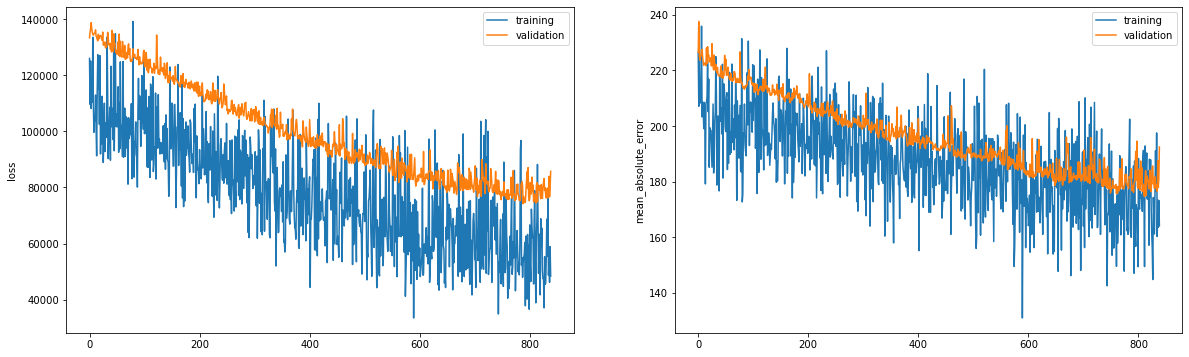

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=df_history.loss, label="training")
sns.lineplot(data=df_history.val_loss, label="validation")
plt.subplot(1, 2, 2)
sns.lineplot(data=df_history.mean_absolute_error, label="training")
sns.lineplot(data=df_history.val_mean_absolute_error, label="validation")
plt.legend()
plt.show()

```R
plot(history)
```

Por último, predecimos a partir del modelo final, y evaluamos su rendimiento
en los datos de prueba. 

Debido al uso de SGD, los resultados varían ligeramente con cada
ajuste. 

Lamentablemente, la función `set.seed()` no garantiza resultados idénticos (ya que el ajuste se realiza en Python), por lo que los resultados serán ligeramente diferentes.

```R
npred <- predict(modnn, x[testid, ])
mean(abs(y[testid] - npred))
```

In [56]:
y_pred = model.predict(X_test)

In [57]:
mae(y_test, y_pred)

192.4752963586566

# Red neuronal multicapa (MNIST)

El paquete `keras` viene con un número de conjuntos de datos de ejemplo, 
incluyendo los datos de dígitos de MNIST. 

Nuestro primer paso es cargar los datos MNIST con la función `dataset_mnist()`.

In [58]:
mnist = keras.datasets.mnist.load_data()

In [59]:
(X_train, y_train), (X_test, y_test) = mnist

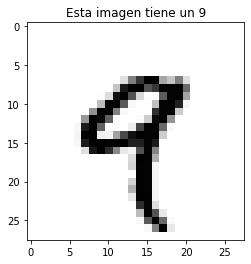

In [60]:
plt.imshow(X_train[4], cmap="Greys")
plt.title(f"Esta imagen tiene un {y_train[4]}")
plt.show()

In [61]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

```
library(keras)
mnist <- dataset_mnist()
x_train <- mnist$train$x
g_train <- mnist$train$y
x_test <- mnist$test$x
g_test <- mnist$test$y
dim(x_train)
dim(x_test)
```

In [62]:
x = keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(X_train[:, :, 1])
x = layers.Flatten()(x)
x = tf.constant(x)
x.numpy().min(), x.numpy().mean(), x.numpy().max()

(0.0, 6.408263e-05, 1.0)

In [63]:
# Get the data as Numpy arrays
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Build a simple model
inputs = keras.Input(shape=(28, 28))

x = keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(rate=0.4)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(rate=0.3)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model for 1 epoch from Numpy data
batch_size = 64
print("Fit on NumPy data")
history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=20)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 28, 28)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0   

In [64]:
df_history = pd.DataFrame(history.history)

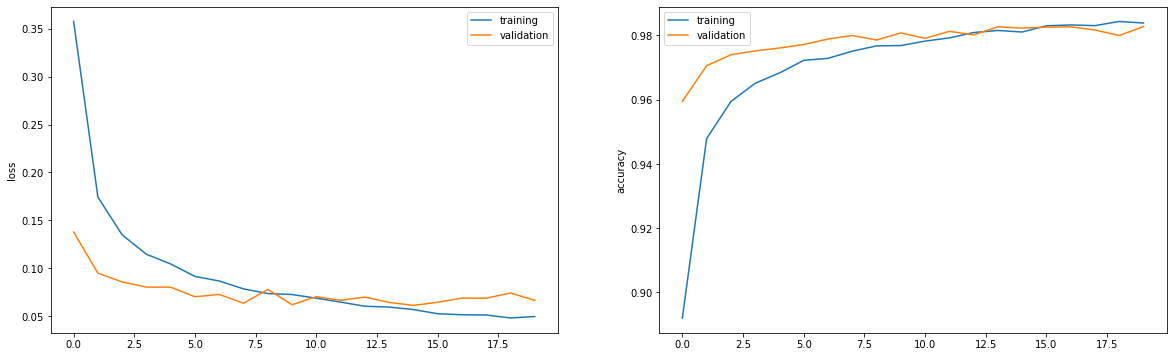

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=df_history.loss, label="training")
sns.lineplot(data=df_history.val_loss, label="validation")
plt.subplot(1, 2, 2)
sns.lineplot(data=df_history.accuracy, label="training")
sns.lineplot(data=df_history.val_accuracy, label="validation")
plt.legend()
plt.show()

Hay $60.000$ imágenes en los datos de entrenamiento y $10.000$ en los datos de prueba.

Las imágenes son de $28×28$, y se almacenan como una matriz tridimensional, por lo que necesitamos
que darles forma de matriz. 

Además, tenemos que codificar la etiqueta de la clase de una sola vez.
etiqueta. 

Por suerte, Keras tiene un montón de funciones incorporadas que hacen esto por nosotros.

```R
x_train <- array_reshape(x_train, c(nrow(x_train), 784))
x_test <- array_reshape(x_test, c(nrow(x_test), 784))
y_train <- to_categorical(g_train, 10)
y_test <- to_categorical(g_test, 10)
```

Las redes neuronales son sensibles a la escala de las entradas. Por ejemplo, la regularización de *ridge* y de *lasso* se ve afectada por la escala. En este caso, las entradas son valores de escala de grises de ocho bits entre $0$ y $255$, por lo que reescalamos al intervalo de la unidad.


```R
x_train <- x_train / 255
x_test <- x_test / 255
```

Ajustamos la red neuronal:

```R
modelnn <- keras_model_sequential()

modelnn %>% layer_dense(units = 256, 
                        activation = "relu",
                        input_shape = c(784)) %>%
            layer_dropout(rate = 0.4) %>%
            layer_dense(units = 128, activation = "relu") %>%
            layer_dropout(rate = 0.3) %>%
            layer_dense(units = 10, activation = "softmax")
```

*Summary* del modelo:


In [ ]:
summary(modelnn)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_6 (Dense)                    (None, 256)                     200960      
                                                                                
 dropout_3 (Dropout)                (None, 256)                     0           
                                                                                
 dense_5 (Dense)                    (None, 128)                     32896       
                                                                                
 dropout_2 (Dropout)                (None, 128)                     0           
                                                                                
 dense_4 (Dense)                    (None, 10)                      1290        
                                                                                
Total 

Los parámetros de cada capa incluyen un término de sesgo, lo que da lugar a un
número de parámetros de $235146$. 

Por ejemplo, la primera capa oculta implica $(784 + 1) × 256 = 200.960$ parámetros.

Minimizamos la *cross-entropy*:

```R
modelnn %>% compile(loss = "categorical_crossentropy",
                    optimizer = optimizer_rmsprop(),
                    metrics = c("accuracy"))
```

Entrenamos el modelo:

```R
system.time(
  history <- modelnn %>% fit(x_train, y_train, 
                             epochs = 30, 
                             batch_size = 128,
                             validation_split = 0.2)
)
```

   user  system elapsed 
146.839  10.264 142.755 

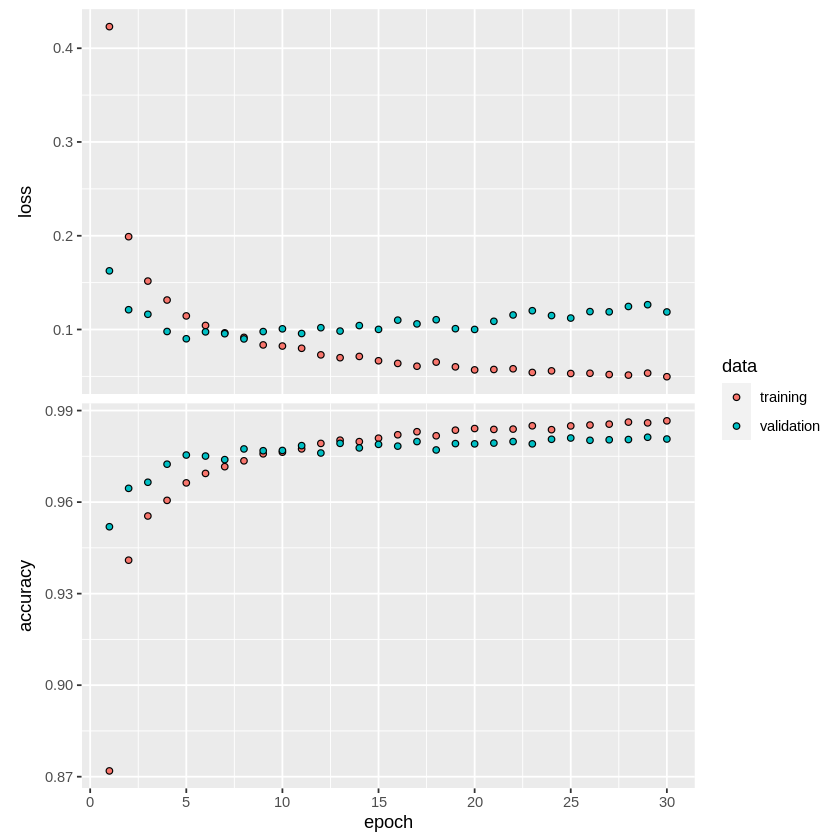

In [ ]:
plot(history, smooth = FALSE)

* El entrenamiento se realiza con el $80%$ de las $60000$ observaciones.
* El SGD utiliza lotes de $128$ observaciones para calcular el gradiente. Una época corresponde a 375 pasos.

Evaluamos nuestras predicciones:

In [67]:
def accuracy(pred, truth):
    return np.mean(pred == truth)

y_pred = model.predict(X_test)  # Esta es simplemente la capa de salida de la RN
y_pred = np.argmax(y_pred, axis=1)  # Aquí predecimos según el valor de máxima activación
accuracy(y_pred, y_test)

0.9828

¿Qué ejemplos están mal clasificados?

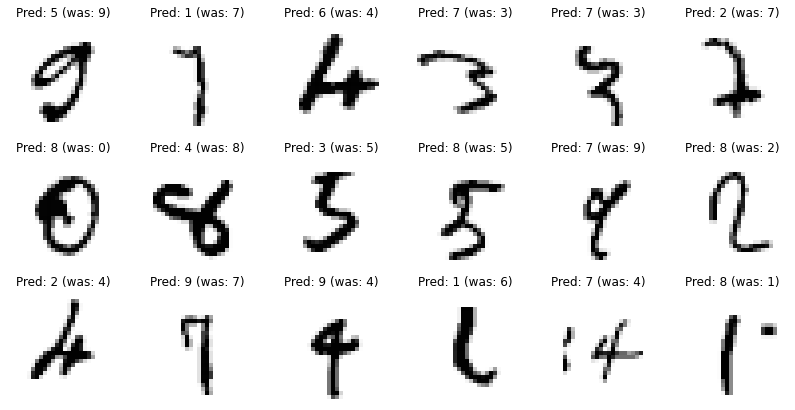

In [68]:
wrongs = np.where(y_pred != y_test)[0]  # Recupera los índices de las obsveraciones mal clasificadas
fig, axs = plt.subplots(3, 6, figsize=(14, 7))
for idx, ax in zip(  # `zip` aparea los elementos de
    np.random.choice(wrongs, 18, replace=False),  #  los índices de 18 dígitos mal clasificados
    fig.axes  # con los 3 * 6 = 18 "subplots" recién creados
):
    ax.imshow(X_test[idx], cmap="Greys")
    ax.set_title(f"Pred: {y_pred[idx]} (was: {y_test[idx]})")
    ax.axis("off")
plt.show()

```R
accuracy <- function(pred, truth)
mean(drop(pred) == drop(truth))

modelnn %>% predict_classes(x_test) %>% accuracy(g_test)
```

Para ajustar una regresión logística basta con omitir la capa oculta.

(`glmnet` es más lento para un dataset grande)

```R
modellr <- keras_model_sequential() % >%
  layer_dense(input_shape = 784, units = 10,
  activation = "softmax")
summary(modellr)
```

In [70]:
# Build a simple model
model = keras.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=X_train.shape[1:]))
model.add(layers.Flatten())
model.add(layers.Dense(units=10, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 28, 28)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [76]:
from sklearn import preprocessing
binarizer = preprocessing.LabelBinarizer().fit(y_train)

In [72]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
    X_train,
    binarizer.transform(y_train),
    epochs = 100,
    batch_size = 128,
    validation_data = (X_test, binarizer.transform(y_test)),
    verbose=0,
    callbacks=[early_stopping_callback],
)

In [73]:
# y_pred = model.predict_classes(X_test)
# keras advierte que `Sequential.predict_classes` está por deprecarse y sugiere
y_pred = np.argmax(model.predict(X_test), axis=-1)
accuracy(y_pred, y_test)

0.9279

In [77]:
df_history = pd.DataFrame(history.history)

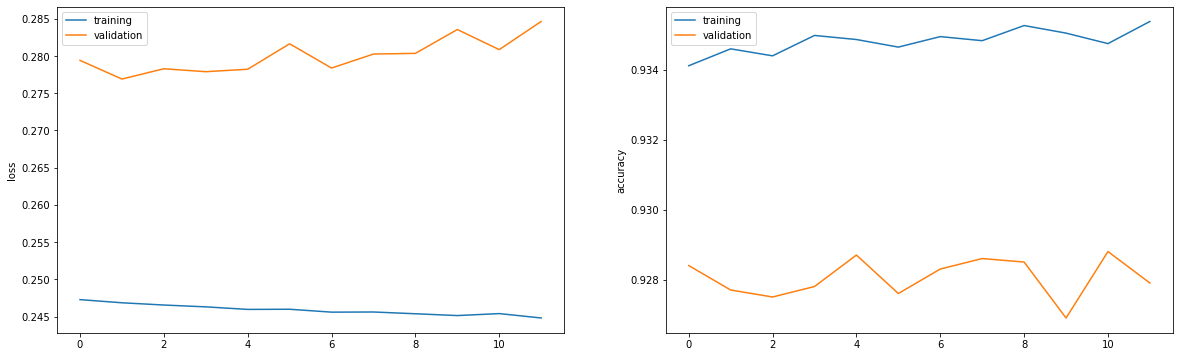

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=df_history.loss, label="training")
sns.lineplot(data=df_history.val_loss, label="validation")
plt.subplot(1, 2, 2)
sns.lineplot(data=df_history.accuracy, label="training")
sns.lineplot(data=df_history.val_accuracy, label="validation")
plt.legend()
plt.show()

Ajustamos el modelo.

```R
modellr %>% compile(loss = "categorical_crossentropy",
                    optimizer = optimizer_rmsprop(), 
                    metrics = c("accuracy"))
modellr %>% fit(x_train, y_train, 
                epochs = 30,
                batch_size = 128, 
                validation_split = 0.2)
modellr %>% predict_classes(x_test) 
        %>% accuracy(g_test)
```

In [101]:
flat_X_train = np.reshape(X_train, (-1, 28 * 28)) / 255
flat_X_test = np.reshape(X_test, (-1, 28 * 28)) / 255

In [102]:
from sklearn.linear_model import LogisticRegression

In [118]:
mn_mod = LogisticRegression(multi_class="multinomial", max_iter=500)
mn_fit = mn_mod.fit(flat_X_train[:10000], y_train[:10000])

In [119]:
accuracy(mn_fit.predict(flat_X_test), y_test)

0.9051

# Ejercicio

Ajustar una red neuronal a los datos `Default`: 
* Utilice una sola capa oculta
con $10$ unidades, y regularización de *dropout*. 
* Compare el rendimiento de clasificación de su modelo con una regresión logística.

In [159]:
default = pd.read_csv("../data/default.csv")

In [160]:
for col in ["default", "student"]:  # codifico binariamente los dos vectores Yes/No
    default[col] = np.array(default[col] == "Yes", dtype=int)
y = default.default
X = default.drop(columns="default")

In [161]:
from sklearn.model_selection import train_test_split

In [162]:
X.shape

(10000, 3)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

In [172]:
model = keras.Sequential()
model.add(layers.Dense(units=10, activation="relu", input_shape=X.shape[1:]))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10)                40        
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [182]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size = 128,
    validation_data = (X_test, y_test),
    verbose=2,
    callbacks=[early_stopping_callback],
)

Epoch 1/1000
16/16 - 0s - loss: 3658.7952 - accuracy: 0.1220 - val_loss: 3334.7600 - val_accuracy: 0.0336
Epoch 2/1000
16/16 - 0s - loss: 3091.6819 - accuracy: 0.1090 - val_loss: 2845.8789 - val_accuracy: 0.0336
Epoch 3/1000
16/16 - 0s - loss: 2689.4519 - accuracy: 0.1130 - val_loss: 2409.0828 - val_accuracy: 0.0336
Epoch 4/1000
16/16 - 0s - loss: 2218.2488 - accuracy: 0.1205 - val_loss: 2010.2958 - val_accuracy: 0.0338
Epoch 5/1000
16/16 - 0s - loss: 1908.4473 - accuracy: 0.2340 - val_loss: 1721.1102 - val_accuracy: 0.0338
Epoch 6/1000
16/16 - 0s - loss: 1612.6638 - accuracy: 0.3120 - val_loss: 1498.8341 - val_accuracy: 0.0338
Epoch 7/1000
16/16 - 0s - loss: 1413.7863 - accuracy: 0.3060 - val_loss: 1291.5354 - val_accuracy: 0.0338
Epoch 8/1000
16/16 - 0s - loss: 1233.2112 - accuracy: 0.3065 - val_loss: 1096.4121 - val_accuracy: 0.0339
Epoch 9/1000
16/16 - 0s - loss: 1010.2798 - accuracy: 0.3285 - val_loss: 921.7149 - val_accuracy: 0.0339
Epoch 10/1000
16/16 - 0s - loss: 877.4775 - acc

In [183]:
df_history = pd.DataFrame(history.history)

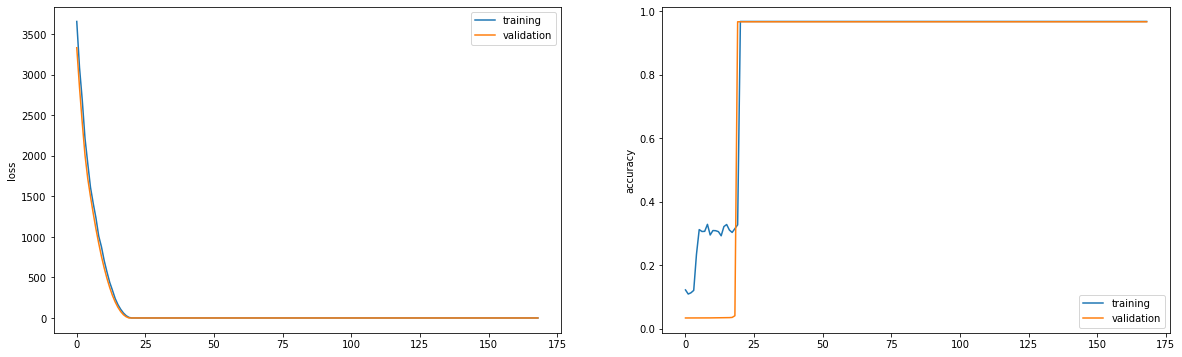

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=df_history.loss, label="training")
sns.lineplot(data=df_history.val_loss, label="validation")
plt.subplot(1, 2, 2)
sns.lineplot(data=df_history.accuracy, label="training")
sns.lineplot(data=df_history.val_accuracy, label="validation")
plt.legend()
plt.show()

In [193]:
y_pred = np.array(model.predict(X_test).reshape(-1) > 0.5, dtype="int")

In [194]:
accuracy(y_test, y_pred)

0.9665

In [196]:
lr_mod = LogisticRegression()
lr_fit = lr_mod.fit(X_train, y_train)
y_pred = lr_fit.predict(X_test)
accuracy(y_test, y_pred)

0.965375

In [202]:
lr_fit.coef_

array([[-2.29715667e-06,  5.48188218e-04, -1.32997374e-04]])